In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets.utils import download_url
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.optim import SGD

In [2]:
DATA_DOWNLOAD_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"

In [3]:
#download_url(url=DATA_DOWNLOAD_URL, root=".")

In [4]:
file_name = "../input/bostonhousingdata/BostonHousing.csv"
data = pd.read_csv(file_name)

In [5]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [6]:
input_data = data.drop(labels='medv', axis=1).values
output_data = data[['medv']].values

In [7]:
dataset = TensorDataset(torch.tensor(input_data, dtype=torch.float32), torch.tensor(output_data, dtype=torch.float32))
len(dataset)

506

In [8]:
dataset[0]

(tensor([6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01, 6.5750e+00,
         6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02, 1.5300e+01, 3.9690e+02,
         4.9800e+00]),
 tensor([24.]))

In [9]:
input_size = 13
output_size = 1

batch_size = 64
learning_rate = 5e-7

In [10]:
train_data, val_data = random_split(dataset, [406, 100]) 

In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size*2)

In [12]:
for xb,yb in train_loader:
    print(xb.shape,yb.shape)

torch.Size([64, 13]) torch.Size([64, 1])
torch.Size([64, 13]) torch.Size([64, 1])
torch.Size([64, 13]) torch.Size([64, 1])
torch.Size([64, 13]) torch.Size([64, 1])
torch.Size([64, 13]) torch.Size([64, 1])
torch.Size([64, 13]) torch.Size([64, 1])
torch.Size([22, 13]) torch.Size([22, 1])


In [13]:
class LinearHousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        output = self.linear(xb)
        return output
    
    def training_step(self, batch):
        inputs, targets = batch
        pred = self(inputs)
        loss = F.mse_loss(pred, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        pred = self(inputs)
        loss = F.mse_loss(pred, targets)
        return {"val_loss" : loss.detach()}
    
    def validation_epoch_end(self, batch_val):
        batch_losses = [eval_loss['val_loss'] for eval_loss in batch_val]
        epoch_loss = torch.stack(batch_losses).mean()
        return {"val_loss": epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch : {0} with val_loss : {1}".format(epoch, result['val_loss']))

In [14]:
optm_func = torch.optim.SGD
model = LinearHousingModel()

In [15]:
def evaluate(model, val_loader):
    val_outputs = [model.validation_step(batch) for batch in val_loader]
    result = model.validation_epoch_end(val_outputs)
    return result

def fit(model, epochs, optm_func, train_loader, val_loader, learning_rate):
    optm = optm_func(model.parameters(), learning_rate)
    history = []    
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optm.step()
            optm.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
val_result = evaluate(model, val_loader)
val_result

{'val_loss': 1637.51220703125}

In [17]:
history = fit(model, 10, optm_func, train_loader, val_loader, learning_rate)

Epoch : 0 with val_loss : 127.778564453125
Epoch : 1 with val_loss : 118.61213684082031
Epoch : 2 with val_loss : 118.2475814819336
Epoch : 3 with val_loss : 116.14234161376953
Epoch : 4 with val_loss : 115.37429809570312
Epoch : 5 with val_loss : 116.29632568359375
Epoch : 6 with val_loss : 114.28903198242188
Epoch : 7 with val_loss : 114.58694458007812
Epoch : 8 with val_loss : 113.290771484375
Epoch : 9 with val_loss : 112.91213989257812


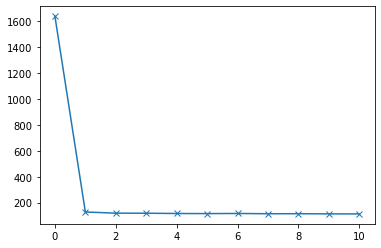

In [18]:
losses = [i["val_loss"] for i in [val_result]+history]
plt.plot(losses, '-x')
plt.show()